<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/K_Mean_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Raw Data into Python

In [91]:
# Loading the data
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Test.csv')

# print the shape
print(train_data.shape)
print(test_data.shape)


#runs the first 5 rows
train_data.head()

(125973, 43)
(22544, 43)


,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,1,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,2,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,3,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,4,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,5,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [92]:
#data = pd.concat([train_data, test_data],axis=0,sort=False)
train_data.drop(['id'], axis = 'columns' , inplace = True)
test_data.drop(['id'], axis = 'columns' , inplace = True)

# Data Preprocessing ¶

In [93]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [94]:
#convert object data to categorical
train_data[['protocol_type', 'service', 'flag','class']]= train_data[['protocol_type', 'service', 'flag','class']].apply(lambda x: x.astype('category'))
test_data[['protocol_type', 'service', 'flag','class']]= test_data[['protocol_type', 'service', 'flag','class']].apply(lambda x: x.astype('category'))

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   duration                     125973 non-null  int64   
 1   protocol_type                125973 non-null  category
 2   service                      125973 non-null  category
 3   flag                         125973 non-null  category
 4   src_bytes                    125973 non-null  int64   
 5   dst_bytes                    125973 non-null  int64   
 6   land                         125973 non-null  int64   
 7   wrong_fragment               125973 non-null  int64   
 8   urgent                       125973 non-null  int64   
 9   hot                          125973 non-null  int64   
 10  num_failed_logins            125973 non-null  int64   
 11  logged_in                    125973 non-null  int64   
 12  num_compromised              125973 non-null

In [95]:
# Checking for null values
print(train_data.isnull().sum())
print(test_data.isnull().sum())


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [106]:
# select categorical column and count unique values 
for column in train_data.select_dtypes('category'):
    unique_vals = np.unique(train_data[column])
    nr_values = len(unique_vals)
    print('{} :{}'.format(column, nr_values))

protocol_type :3
service :31
flag :11
class :2


In [97]:
print(".....................protocol_type.........................\n")
print(train_data['protocol_type'].describe())
print("\n\n.....................service.........................\n")
print(train_data['service'].describe())
print("\n\n......................flag........................\n")
print(train_data['flag'].describe())


.....................protocol_type.........................

count     125973
unique         3
top          tcp
freq      102689
Name: protocol_type, dtype: object


.....................service.........................

count     125973
unique        70
top         http
freq       40338
Name: service, dtype: object


......................flag........................

count     125973
unique        11
top           SF
freq       74945
Name: flag, dtype: object


In [98]:
train_data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

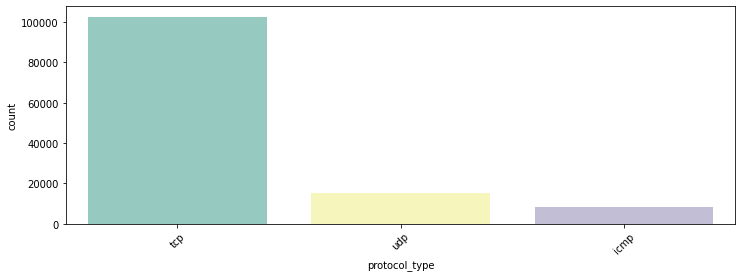

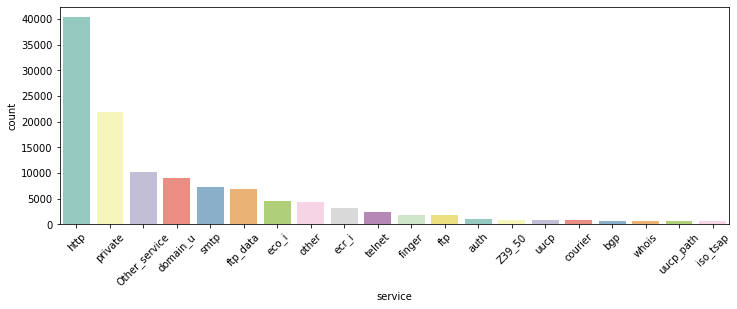

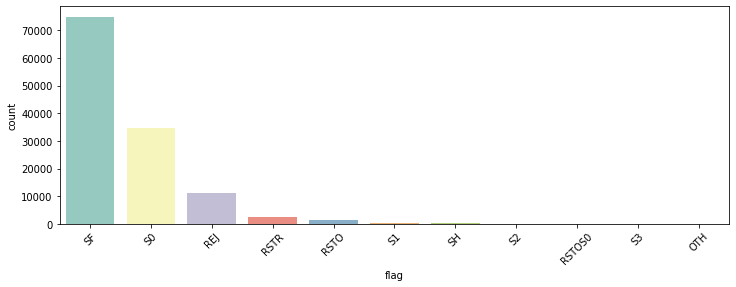

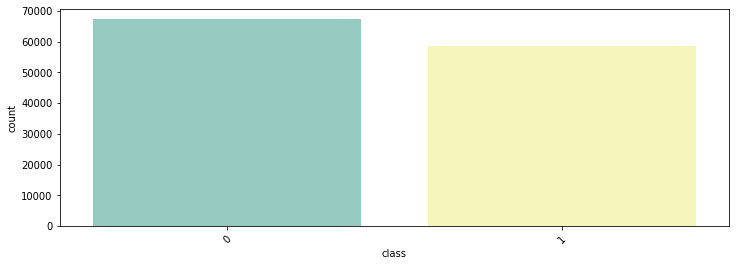

In [105]:
# Looping through all the features by our y variable - see if there is relationship

features = ['protocol_type', 'service', 'flag', 'class']
for f in features:
    plt.figure(figsize=(12,4)) # this creates a figure 8 inch wide, 4 inch high

    sns.countplot(x = f, data = train_data, palette = 'Set3',order = train_data[f].value_counts().iloc[:20].index)
    plt.xticks(rotation=45)
    plt.show()
    

In [100]:
train_data['class'] = train_data['class'].map( {'normal':0, 'anomaly':1} )
test_data['class'] = test_data['class'].map( {'normal':0, 'anomaly':1} )

In [104]:
train_data['service']

0              ftp_data
1                 other
2               private
3                  http
4                  http
              ...      
125968          private
125969          private
125970             smtp
125971    Other_service
125972         ftp_data
Name: service, Length: 125973, dtype: category
Categories (31, object): ['Z39_50', 'auth', 'bgp', 'courier', ..., 'uucp_path', 'vmnet', 'whois',
                          'Other_service']

In [103]:
otherlabel = 'Other_service'
others1 = train_data['service'].value_counts().index[30:]
# apply new category label
train_data['service'] = train_data['service'].cat.add_categories([otherlabel])
train_data['service'] = train_data['service'].replace(others1, otherlabel)

train_data['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                            'link':'Other_service','name':'Other_service','echo':'Other_service',
                            'netbios_ns':'Other_service'}, inplace = True)


In [109]:
otherlabel = 'Other_service'
others1 = test_data['service'].value_counts().index[30:]
# apply new category label
test_data['service'] = test_data['service'].cat.add_categories([otherlabel])
test_data['service'] = test_data['service'].replace(others1, otherlabel)

test_data['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                            'link':'Other_service','name':'Other_service','echo':'Other_service',
                            'netbios_ns':'Other_service'}, inplace = True)


In [111]:
print('Duplicates :',train_data.duplicated().sum())
train_data.drop_duplicates(keep='first',inplace=True)
train_data.duplicated().sum()

Duplicates : 0


0

In [112]:
print('Duplicates :',test_data.duplicated().sum())
test_data.drop_duplicates(keep='first',inplace=True)
test_data.duplicated().sum()

Duplicates : 0


0

In [113]:

train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [114]:
limit = train_data.shape[1]-1
    
X_train = train_data.iloc[:,0:limit] # train set features
Y_train = train_data.iloc[:,limit]

    
X_test = test_data.iloc[:,0:limit] # test set features
Y_test = test_data.iloc[:,limit]

print('Training X   :',X_train.shape)
print('Training_Y   :',Y_train.shape)
print('Test_X       :',X_test.shape)
print('Test_Y       :',Y_test.shape)

Training X   : (124997, 41)
Training_Y   : (124997,)
Test_X       : (22514, 41)
Test_Y       : (22514,)


In [115]:
def one_hot_encode(X_train,X_test):# Making categorical variables into numeric representation by one- hot encoding
    
    categorical_cols = ['protocol_type','flag','service']

    # Training dataset one hot encoding
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(X_train[categorical_cols])
    array_hot_encoded1 = ohe.transform(X_train[categorical_cols]).toarray()

    data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index,columns=ohe.get_feature_names(categorical_cols))
    X_train = X_train.drop(columns=categorical_cols)
    X_train = pd.concat([data_hot_encoded1,X_train], axis=1)
    
    print('X_train shape :',X_train.shape)
    
    # Test dataset one hot encoding
    array_hot_encoded2 = ohe.transform(X_test[categorical_cols]).toarray()
    data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index,columns=ohe.get_feature_names(categorical_cols))
    X_test = X_test.drop(columns=categorical_cols)
    X_test = pd.concat([data_hot_encoded2,X_test], axis=1)
    
    print('X_test shape :',X_test.shape)
    
    return X_train, X_test



X_train, X_test = one_hot_encode(X_train,X_test)


X_train shape : (124997, 83)
X_test shape : (22514, 83)


In [116]:
X_train


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_Other_service,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_discard,service_domain,service_domain_u,service_eco_i,service_ecr_i,service_finger,service_ftp,service_ftp_data,service_http,service_http_443,service_imap4,service_iso_tsap,service_nnsp,service_other,service_private,service_smtp,service_supdup,service_telnet,service_time,...,service_vmnet,service_whois,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124992,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00
124993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00
124994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00
124995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [117]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


#print(X_value.mean())

#print(X_value.std())

In [118]:
X_train.describe()


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_Other_service,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_discard,service_domain,service_domain_u,service_eco_i,service_ecr_i,service_finger,service_ftp,service_ftp_data,service_http,service_http_443,service_imap4,service_iso_tsap,service_nnsp,service_other,service_private,service_smtp,service_supdup,service_telnet,service_time,...,service_vmnet,service_whois,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,...,124997.000000,124997.000000,124997.000000,1.249970e+05,1.249970e+05,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.0,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000,124997.000000
mean,0.066258,0.813796,0.119947,0.000368,0.088970,0.012424,0.000824,0.019144,0.272391,0.002920,0.001016,0.000392,0.599502,0.002048,0.073234,0.006896,0.007640,0.005680,0.005872,0.004360,0.004504,0.004304,0.004552,0.072346,0.036657,0.024577,0.014136,0.014032,0.054881,0.322712,0.004240,0.005176,0.005496,0.005040,0.034873,0.174828,0.058505,0.004352,0.018824,0.005232,...,0.004936,0.005544,0.006744,3.327807e-05,1.521718e-05,0.000200,0.007622,0.000037,0.002675,0.000246,0.398826,0.000038,0.001352,0.000556,0.000041,0.000297,0.000208,0.000459,0.0,0.000008,0.009496,0.162902,0.054516,0.280159,0.278147,0.119706,0.120937,0.664946,0.062924,0.098058,0.712150,0.456704,0.524867,0.082634,0.148966,0.032797,0.280125,0.274115,0.118577,0.119987
std,0.248733,0.389273,0.324901,0.019180,0.284702,0.110770,0.028694,0.137033,0.445192,0.053959,0.031859,0.019795,0.490001,0.045209,0.260521,0.082757,0.087074,0.075153,0.076405,0.065887,0.066962,0.065465,0.067316,0.259061,0.187919,0.154831,0.118053,0.117625,0.227749,0.467515,0.064978,0.071759,0.073932,0.070815,0.183458,0.379822,0.234698,0.065827,0.135905,0.072144,...,0.070084,0.074253,0.060934,4.270549e-03,3.081779e-03,0.014141,0.084837,0.004807,0.028029,0.009083,0.489659,0.003214,0.036745,0.022665,0.003280,0.011298,0.011134,0.011084,0.0,0.002828,0.096985,0.223574,0.142666,0.444307,0.444860,0.320104,0.323338,0.438417,0.180544,0.260663,0.389699,0.434326,0.448731,0.188536,0.309279,0.112966,0.442615,0.443450,0.306114,0.319113
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

# K-means Clustering

In [120]:
# Running K means with multible Ks
best_seed = None


min_inertia=0.0
no_of_clusters = 2
seeds = [0,9500,10000,10500,11000,15000,18000 , 20000, 40000, 60000, 80000,90000, 120000]
for seed in seeds:

  
  print('\n\n seed= {} \n'.format(seed))
   
  kmeans = KMeans(n_clusters=no_of_clusters, init='k-means++',random_state=seed)
  kmeans = kmeans.fit(X_train)
  
  inertia = kmeans.inertia_
  print("The innertia for : 2 Clusters is:", inertia) 
  # if current measurement of heterogeneity is lower than previously seen,
  # update the minimum record of heterogeneity.
  if min_inertia == 0 :
      min_inertia = inertia
      best_seed = seed
  if inertia < min_inertia:
      min_inertia = inertia
      best_seed = seed
      

print("Min inertia : ", min_inertia)
print("Best Seed : ",best_seed)



 seed= 0 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 9500 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 10000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 10500 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 11000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 15000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 18000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 20000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 40000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 60000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 80000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 90000 

The innertia for : 2 Clusters is: 333374.45685987134


 seed= 120000 

The innertia for : 2 Clusters is: 333374.45685987134
Min inertia :  333374.45685987134
Best Seed :  0


In [121]:
# Running K means on K clusters

kmeans = KMeans(n_clusters=no_of_clusters,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_train)

In [122]:
label0 = 1- kmeans.labels_
label0.shape

(124997,)

In [123]:
label1 = kmeans.labels_
label1.shape

(124997,)

In [124]:
accuracy_score(Y_train,label0)*100

18.982055569333664

In [125]:
accuracy_score(Y_train,label1)*100

81.01794443066633

In [126]:
test_label1 = kmeans.predict(X_test)
test_label0 = 1 - test_label1

In [127]:
accuracy_score(Y_test,test_label0)*100


47.10402416274318

In [128]:
accuracy_score(Y_test,test_label1)*100

52.89597583725681

In [ ]:
predictions = kmeans.predict(X_test)

## Temp


In [ ]:
'''# Running K means with multible Ks
best_seed = None
final_centroids = None
final_cluster_assignment = None

min_inertia = []
X_value = X_train
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
  inertia = []
  no_of_clusters = range(2,15)
  print('\n\n seed= {} \n'.format(seed))
  for f in no_of_clusters:
      kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
      kmeans = kmeans.fit(X_value)
      
      u = kmeans.inertia_
      inertia.append(u)
      print("The innertia for :", f, "Clusters is:", u) 
      # if current measurement of heterogeneity is lower than previously seen,
      # update the minimum record of heterogeneity.
  if len(min_inertia) == 0 :
      min_inertia = inertia
      
  if min(inertia,default=0) < min(min_inertia,default=0):
      min_inertia = inertia
      best_seed = seed
      final_centroids = kmeans.cluster_centers_
      final_cluster_assignment = kmeans.labels_

      '''

SyntaxError: ignored

In [ ]:
# Creating the screen plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(seeds))
ax1.plot(xx, min_inertia,linewidth=4)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Seed value')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per 2 cluster for Seed ')

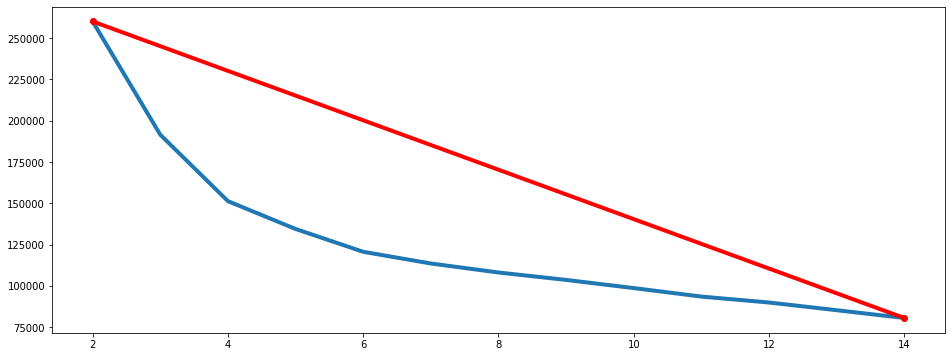

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, min_inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [min_inertia[0], 
                        min_inertia[-1]], 'ro-',linewidth=4)
plt.show()



In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

13

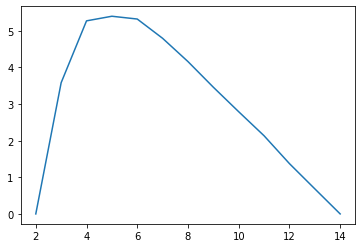

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

Best K value : 5


In [ ]:
# Running K means on K clusters

kmeans = KMeans(n_clusters=K,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_value)
kmeans.inertia_

predictions = kmeans.predict(X_value)




In [ ]:
# calculating the Counts of the cluster
#unique, counts = np.unique(kmeans.labels_, return_counts=True)

print(np.bincount(kmeans.labels_))


[26595 12704 12865 15780 20788]


Explained variance ratio (first two components): [0.389118 0.172485]


<Figure size 432x288 with 0 Axes>

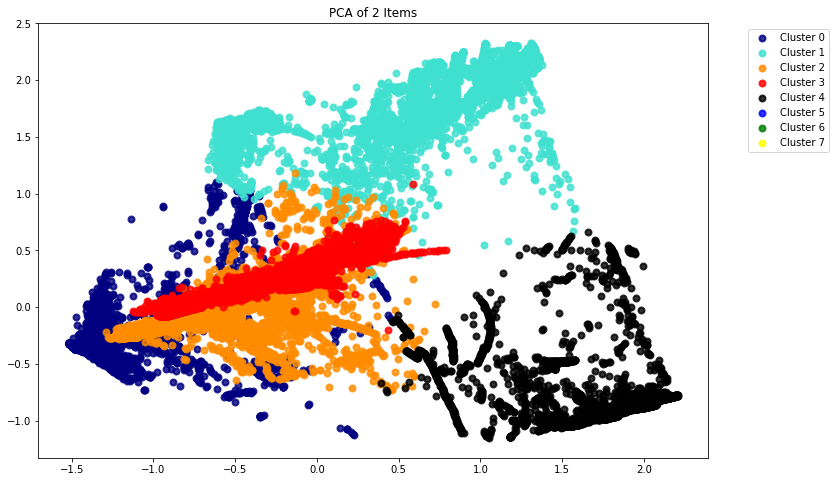

In [ ]:
# Running PCA to Visualize the data

X = X_value

y_num = predictions

pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X).transform(X)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','blue','green','yellow']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4,5,6,7], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

In [ ]:
# Trying with Dimentionality reduction and then Kmeans

n_components = X.shape[1]

# Running PCA with all components
pca = PCA(n_components=n_components, random_state = best_seed)
X_r = pca.fit(X).transform(X)


# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_98 = total_variance * 0.98
print("The 98% variance we want to have is: ", var_98)
print("")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
print("Variance explain with 30 n_compononets: ", sum(a["Explained Variance"][0:30]))
print("Variance explain with 35 n_compononets: ", sum(a["Explained Variance"][0:35]))
print("Variance explain with 40 n_compononets: ", sum(a["Explained Variance"][0:40]))
print("Variance explain with 41 n_compononets: ", sum(a["Explained Variance"][0:41]))
print("Variance explain with 50 n_compononets: ", sum(a["Explained Variance"][0:50]))
print("Variance explain with 53 n_compononets: ", sum(a["Explained Variance"][0:53]))
print("Variance explain with 55 n_compononets: ", sum(a["Explained Variance"][0:55]))
print("Variance explain with 60 n_compononets: ", sum(a["Explained Variance"][0:60]))


Total Variance in our dataset is:  4.467523553024
The 98% variance we want to have is:  4.37817308196352

Variance explain with 30 n_compononets:  4.275788841758899
Variance explain with 35 n_compononets:  4.304523154664949
Variance explain with 40 n_compononets:  4.3282978585500285
Variance explain with 41 n_compononets:  4.332796936695783
Variance explain with 50 n_compononets:  4.36962345035382
Variance explain with 53 n_compononets:  4.380536080164494
Variance explain with 55 n_compononets:  4.387555740981465
Variance explain with 60 n_compononets:  4.403646115422531


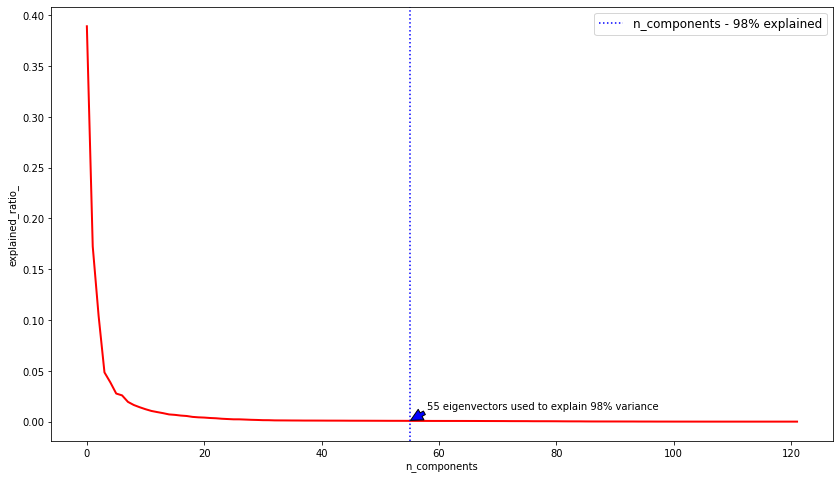

In [ ]:

# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c="r")
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 98% e.v.
plt.axvline(55,linestyle=':', label='n_components - 98% explained', c ="blue")
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate('55 eigenvectors used to explain 98% variance', xy=(55, pca.explained_variance_ratio_[55]), 
             xytext=(58, pca.explained_variance_ratio_[10]),
            arrowprops=dict(facecolor='blue', shrink=0.05))

plt.show()

The innertia for : 2 Clusters is: 252916.93000430646
The innertia for : 3 Clusters is: 184359.73555825485
The innertia for : 4 Clusters is: 144144.18485094127
The innertia for : 5 Clusters is: 127305.20334183748
The innertia for : 6 Clusters is: 113487.78545164135
The innertia for : 7 Clusters is: 106410.82380433177
The innertia for : 8 Clusters is: 99656.14572864691
The innertia for : 9 Clusters is: 94511.8923308962
The innertia for : 10 Clusters is: 90791.453529017
The innertia for : 11 Clusters is: 85351.91169098065
The innertia for : 12 Clusters is: 80247.6466307153
The innertia for : 13 Clusters is: 77074.5650381497
The innertia for : 14 Clusters is: 73947.25641550876


Text(0.5, 1.0, 'Inertia Plot per k')

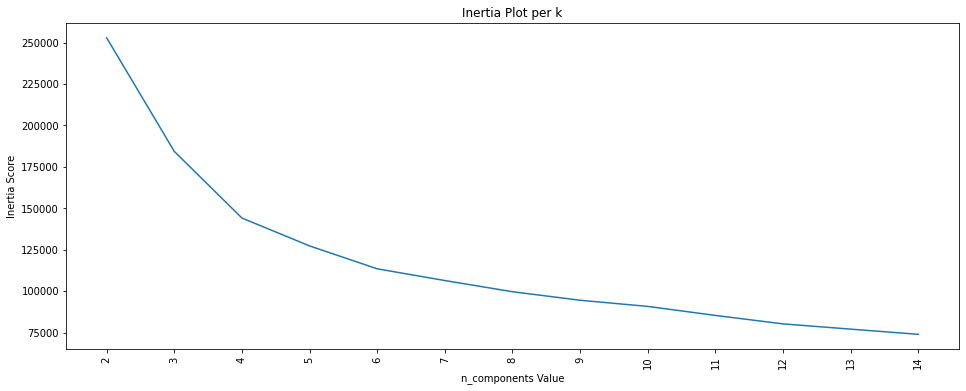

In [ ]:
# Running PCA again

pca = PCA(n_components=55, random_state = 453)
X_r = pca.fit(X).transform(X)

inertia = []

#running Kmeans

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=best_seed)
    kmeans = kmeans.fit(X_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)

# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

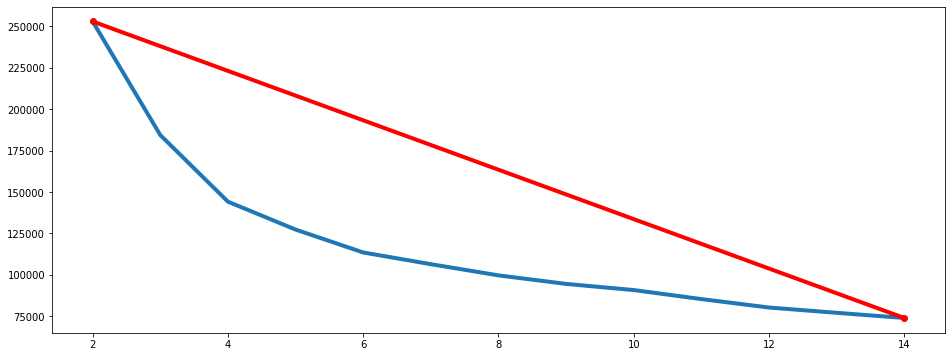

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [inertia[0], 
                        inertia[-1]], 'ro-',linewidth=4)
plt.show()


In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

13

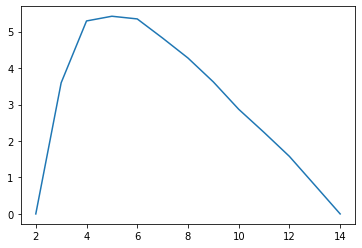

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

Best K value : 5


In [ ]:
# Running PCA with 36 PC

# Running Kmeans with 5 Ks
kmeans = KMeans(n_clusters=5, random_state=best_seed)
kmeans = kmeans.fit(X_r)

print("Optimized K-mean innertia for cluster 5 :", kmeans.inertia_)

Optimized K-mean innertia for cluster 5 : 127305.20334183748


Explained variance ratio (PCA 2 components): 0.571890137114337


<Figure size 432x288 with 0 Axes>

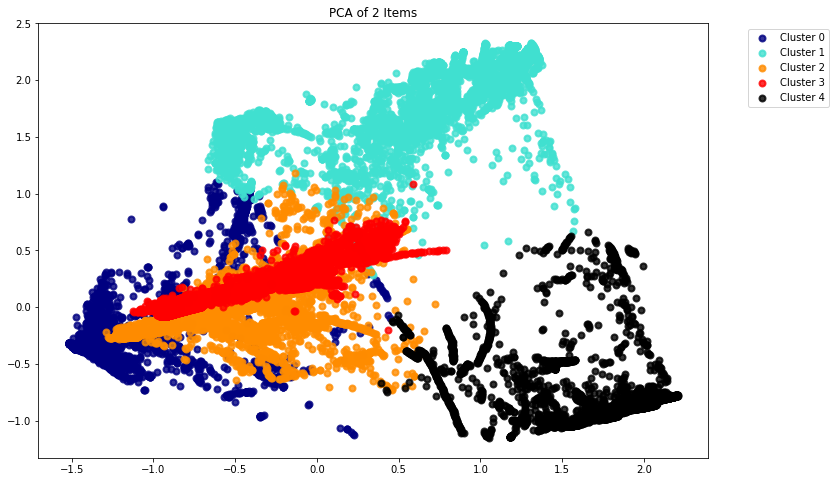

In [ ]:
# Running PCA to Visualize the data


pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X_r).transform(X_r)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

# Percentage of variance explained for each components
print('Explained variance ratio (PCA 2 components): %s' % str(sum(pca.explained_variance_ratio_)))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()